In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Math #para escrever equações 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [ ]:
from random import randint
from xmlrpc.client import Boolean
from tqdm import tqdm
import pandas as pd
import numpy as np
import quantecon as qe

import logging
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG) 


In [ ]:
RANDOM_SIZE   = 1000000
RANDOM_SIZE   = 1003
# QTD_BINS      = 3
TEST_SIZE     = 0.05
RANDOM_STATE  = 2022

- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_commodity_types.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_vegetable_oil.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv

# Mercado de Oleo

## Dataset Completo
USDA por comodity
USDA Agrupado por Oleo Vegetal
OECD Agrupado
FAO Index Price


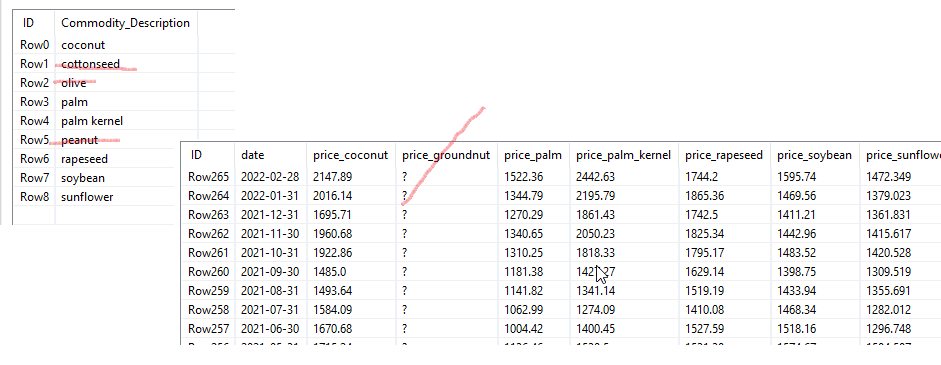

In [ ]:

def get_dataset():
    df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv')
    print(df.shape)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'], ascending=[True], inplace=True)
    df.set_index(['date'], inplace=True)
    return df

%time df_full = get_dataset()
df_full.head()

In [ ]:
df_full.info()

In [ ]:
df_full.dtypes

In [ ]:
features = [x for x in df_full.columns if ('exports' in x or 'production' in x or 'price' in x) and not ('olive' in x or 'cottonseed' in x) ]
prices = [x for x in df_full.columns if 'price' in x and 'groundnut' not in x  ]
print(len(features), features)
print(len(prices), prices)

In [ ]:
df = df_full[features]
print(df.shape)
df = df[df['sunflower_production'].notnull()]
df = df[df['sunflower_price'].notnull()]
print(df.shape)
df

In [ ]:
df.describe()

## Correlação

Paired density and scatterplot matrix

https://seaborn.pydata.org/examples/pair_grid_with_kde.html

In [ ]:
if False:
    %time
    sns.set_theme(style="white")

    g = sns.PairGrid(df, diag_sharey=False)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)

![Alt text](https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/images/Compare.png)

## Dendograma

In [ ]:
if False:
    plt.figure(figsize=(25,10))
    dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))

    plt.title('Dendrogram')

    # plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    %time plt.show()

# Markov

In [ ]:
!pip install --upgrade quantecon numba tqdm

In [ ]:
df.tail()

## Geração do Random Sets

In [ ]:
def prepare_dataset(df: pd.DataFrame):
    df = df.copy()
    for col in df.columns:
        df[f'{col}_delta']    = df[col].diff()
        df[f'{col}_outcome']  = df[col].diff(-1) * -1
        df[f'{col}_mom']      = df[col].pct_change()

    columns = sorted(list(df.columns))
    return df[columns].reset_index()


df_m = prepare_dataset(df)
df_m.tail(10).T

In [ ]:
df_m.tail()

In [ ]:
def get_random_sets(input_dataframe: pd.DataFrame, 
                    size = 100000,
                    **kwargs):
    
    # take random sets of sequential rows 
    new_set = []

    # breakpoint()
    
    log.debug(f'AQUI:   {size}')
    for row_set in (tqdm(iterable = range(0, size), bar_format='{desc:<15}{percentage:3.0f}%|{bar:50}{r_bar}' ) ):
        
        # obtem de forma randomica uma amostra de n linhas do dataset
        # entre 3 e 18 meses
        row_quant     = randint(3, 18)
        row_start     = randint(0, len(input_dataframe) - row_quant)
        row_finish    = row_start + row_quant
        
        market_subset = input_dataframe.iloc[row_start:row_finish]

        # log.debug(f'AQUI:   {row_start} |{row_finish} | {market_subset.shape}')
        
        Close_Date    = max(market_subset['date'])
        

        if row_set%(size//5)==0:
            pass
            print(f'row_set: {row_set:<6} | row_quant: {row_quant:2} | rows: {row_start:>6}-{row_finish-1:<6} | market_subset: {str(market_subset.shape):^10} | Close_Date: {Close_Date:%m/%d/%Y}')
        
        ref = {}
        ref['Sequence_ID']  = [row_set]*len(market_subset)          # poderia ser 'row_quant' ao inves de 'len(market_subset)'
        ref['Close_Date']   = [Close_Date]*len(market_subset)
        ref['ref_date']   = market_subset['date']
        
        columns_ref = {}
        
        if 'columns' in kwargs and isinstance(kwargs['columns'], list):
            for _col in kwargs['columns']:
                if _col in input_dataframe.columns:
                    columns_ref[_col] = market_subset[_col]
                    columns_ref[f'{_col}_variation'] = market_subset[_col].pct_change()
                    
                    if 'outcomes' in kwargs and isinstance(kwargs['outcomes'], list) and _col in kwargs['outcomes']:
                        columns_ref[f'{_col}_outcome'] = market_subset[_col].diff(-1) * -1
            
        
        if 'bypass' in kwargs and isinstance(kwargs['bypass'], list):
            for _col in kwargs['bypass']:
                columns_ref[_col] = market_subset[_col]
               
        # columns_ref = dict( sorted(columns_ref.items(), key=lambda x: x[0].lower()) )
        
        #merge dictionaries
        ref = {**ref, **columns_ref}
        
        new_set.append(pd.DataFrame(ref))
        
    return new_set

# get_random_sets(df_m, RANDOM_SIZE)

In [ ]:
%time my_set_case1 = get_random_sets(df.reset_index(), RANDOM_SIZE,columns=features,  outcomes=features, bypass=[])

In [ ]:
def convet_collection_to_dataframe(collection):
    """
    Concatena todas as colecoes
    Remove os np.inf e np.nan, gerados pelo pc_c
    """
    df_out = pd.concat(collection)
    
    log.debug(f'Before dropping NaNs: {df_out.shape}')
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_out = df_out.dropna(how='any') 
    log.debug(f'After dropping NaNs: {df_out.shape}')
    return df_out

In [ ]:
%time df1 = convet_collection_to_dataframe(my_set_case1)
df1

In [ ]:
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

## Divisao em Quantis

In [ ]:
get_divison = lambda size: [item / size for item in list(range(size + 1))]
get_labels = lambda size: [f'{chr( (item % 26) + 65 )}{ "" if item // 26 <= 0 else item // 26 }' for item in list(range(size))]
get_full = lambda size: [ (chr(i + 65), f'{j / size} < x <= { (j+1) / size}' ) for i , j in enumerate(range(size))]
get_bins = lambda _input_array, size:  np.round(np.linspace(_input_array.min(), _input_array.max(), size + 1), 6).tolist()


def read_kwarg_list(kwargs, name, _else_conditions = None):
    if name in kwargs and isinstance(kwargs[name], list):
        return kwargs[name]
    return _else_conditions

def read_kwarg_bool(kwargs, name):
    if name in kwargs and isinstance(kwargs[name], Boolean):
        return kwargs[name]
    return False
        

In [ ]:
def quantiles_v1(df: pd.DataFrame, labels: list):
    df    = df.copy()
    ref   = ''.join(labels).lower()
    size  = len(labels)

    columns_labels = []
    for col in df.columns:
        if 'variation' in col:
            column_name         = f'{col}_qcut'
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_labels.append(column_name)

    equation = ' + '.join( [f'df["{col}"].astype(str)' for col in columns_labels] )
    df['event_pattern']  = eval(equation) 
    columns_labels.append('event_pattern')

    return df
    return df[['Sequence_ID','Close_Date'] + columns_labels]
    

In [ ]:
df2 = quantiles_v1(df1, ['L','M','H'])
print(df2.shape)
df2.tail()

In [ ]:
outcomes

## Compressing

In [ ]:
def compress_v1(input_dataframe: pd.DataFrame, **kwargs):
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    if columns and 'event_pattern' in input_dataframe.columns:
        df_step1 = input_dataframe.groupby(columns)['event_pattern'].apply(lambda x: ','.join(x)).reset_index()
        
    if columns and outcomes:
        df_step2 = input_dataframe.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on= columns, how='inner')
    
    return compressed_set

In [ ]:
df3 = compress_v1(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

In [ ]:
df3.columns

## Simplificando o Dataset

In [ ]:
df3[outcomes].describe()

In [ ]:
# df3[[x for x in df_full.columns if 'outcome' in x and 'prices' in x  ]].describe()

In [ ]:
relevant_cut_off  = 1 #variacao maior que 1 ponto 
outcome_reference = 'price_index_fao_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

In [ ]:
df4

## Determinando vetores de direção

In [ ]:
def directions(df: pd.DataFrame):
    df    = df.copy()

    for col in [x for x in df.columns if 'outcome' in x ]:
        column_name         = f'{col}_direction'
        df[column_name]     = df[col].apply(lambda x: 1 if x > 0 else -1 )

    columns_fixed   = list(df.columns[:4])
    columns_sort    = sorted(list(df.columns[4:]))
    return df[columns_fixed + columns_sort].sort_values(by = ['Close_Date'], ascending=[False])


In [ ]:
#sem simplificacao
%time df5 = directions(df3)
df5

## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [ ]:
feature_directions = ['event_pattern'] + [x for x in df5.columns if 'direction' in x ]

In [ ]:
X = df5[ feature_directions ]
y = df5[['price_index_fao_outcome']]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

In [ ]:
X_train

In [ ]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*80)
print('Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. ')
print('=='*80)

X_train[[x for x in df5.columns if 'direction' in x ]].sum()

In [ ]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos_case1 = X_train.loc[X_train[direction_reference] > 0]
df6_neg_case1 = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos_case1.shape} | df6_neg: {df6_neg_case1.shape}')

## Matriz de Markov

Matriz estocastica
- cada elemento da matriz é positivo
- a somatoria de cada linha é 1

In [ ]:
X_train_case1 = X_train.copy()

In [ ]:
def get_unique_patterns_V1(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    flat_list = [ item.split(',') for item in input_array ]
    unique_patterns = ','.join(str(r) for v in flat_list for r in v)
    unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
    return unique_patterns

In [ ]:
# flat_list = [ item.split(',') for item in X_train['event_pattern'].values ]
# unique_patterns = ','.join(str(r) for v in flat_list for r in v)
# unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
# unique_patterns

In [ ]:
unique_patterns = get_unique_patterns_V1(X_train_case1['event_pattern'].values)
print(len(unique_patterns), unique_patterns[:3])

In [ ]:
def build_transition_grid_v1(input_dataframe: pd.DataFrame, unique_patterns):
    # log.debug(f'unique_patterns ==> {unique_patterns}')
    
    # build the markov transition grid

    patterns = []
    counts = []
    counts_fk = {}
    
    # de
    for from_event in unique_patterns:
        # para
        
        for to_event in unique_patterns:
            
            pattern = from_event + ',' + to_event # MMM,MlM
            

            ids_matches = input_dataframe[input_dataframe['event_pattern'].str.contains(pattern)]
            
            
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['event_pattern'].values)
                found = Event_Pattern.count(pattern)
                
#             log.debug(f'pattern => {pattern} | ids_matches: {len(ids_matches)} | found: {found} ')
            patterns.append(pattern)
            counts.append(found)
            
            counts_fk[pattern] = f'{len(ids_matches)}|{found}'
    
    # log.debug(f'patterns: {patterns}')
    # log.debug(f'counts: {counts}')
    # log.debug(counts_fk)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})
    
    # return grid_Df

    ## Warning
    # grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',').str
    
    grid_Df[['x', 'y']] = grid_Df['pairs'].str.split(',', n=1, expand=True)
    
    # return grid_Df

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')
    
    # return grid_Df

    # log.debug(f'Antes Columns :{grid_Df.columns}')
    grid_Df.columns= [col for col in grid_Df.columns]
    # log.debug(f'Depois Columns :{grid_Df.columns}')
    
    # return grid_Df
   

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    
    grid_Df['soma'] = grid_Df.sum(axis=1)
    
    # return grid_Df

    # grid_Df.rowSums(transition_dataframe) 
    # grid_Df = grid_Df / grid_Df['soma']
    
    for col in grid_Df.columns:
        grid_Df[col] = grid_Df[col]/grid_Df['soma']
        
        
    del grid_Df['soma']

    return grid_Df

In [ ]:
%time grid_pos = build_transition_grid_v1(df6_pos_case1, unique_patterns) 
grid_pos.to_excel('grid_case1_pos.xlsx')
grid_pos

In [ ]:
%time grid_neg = build_transition_grid_v1(df6_neg_case1, unique_patterns)
grid_neg.to_excel('grid_case1_neg.xlsx')
grid_neg

# Markov 2
-Tentativa de segregar os patterns em:
- product_variation
- exports_variation
- price variation

Para ter padroes menores.

## Geração do Random Sets

In [ ]:
%time my_set_case2 = get_random_sets(df.reset_index(), RANDOM_SIZE,columns=features,  outcomes=features, bypass=[])

In [ ]:
%time df1 = convet_collection_to_dataframe(my_set_case2)
df1

In [ ]:
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

## Divisao em Quantis

In [ ]:
def quantiles_v2(df: pd.DataFrame, labels: list):
    df    = df.copy()
    ref   = ''.join(labels).lower()
    size  = len(labels)

    columns_production  = []
    columns_exports     = []
    columns_prices      = []
    for col in df.columns:
        column_name         = f'{col}_qcut'
        
        if 'production_variation' in col:

            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_production.append(column_name)
            
        elif 'exports_variation' in col:
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_exports.append(column_name)            
            
        elif 'price_variation' in col:
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_prices.append(column_name)  
            
    def get_equation(columns):
        return ' + '.join( [f'df["{col}"].astype(str)' for col in columns] )
        
    df['event_pattern_production']  = eval(get_equation(columns_production)) 
    df['event_pattern_exports']     = eval(get_equation(columns_exports)) 
    df['event_pattern_prices']      = eval(get_equation(columns_prices)) 
    
    columns_fixed   = list(df.columns[:4])
    columns_sort    = sorted(list(df.columns[4:-3]))
    columns_event   = sorted(list(df.columns[-3:]))
    
    columns_production.append('event_pattern')

    return df[columns_fixed + columns_sort + columns_event].sort_values(by = ['Close_Date'], ascending=[False])
    return df
    return df[['Sequence_ID','Close_Date'] + columns_production]
    

In [ ]:
df2 = quantiles_v2(df1, ['L','M','H'])
print(df2.shape)
df2.tail()

## Compressing

In [ ]:
def compress_v2(df: pd.DataFrame, **kwargs):
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    event_patterns = [x for x in df2.columns if 'event_pattern' in x  ]

    if columns and len(event_patterns) >= 1:
        #Nao pode usar o set... pois precisa-se da repeticao para compararcao entre fors
        # da funcao build_transition_grid_v2
        df_step1 = df.groupby(columns)[event_patterns].\
                    agg(lambda x: ','.join( list( x ) ) )
#         df_step1 = df.groupby(columns)[event_patterns].\
#                     agg(lambda x: list( set(x) ) ) 
        
    if columns and outcomes:
        df_step2 = df.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on=columns, how='inner')
           
    return compressed_set

In [ ]:
df3 = compress_v2(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

In [ ]:
df3.columns

## Simplificando o Dataset

In [ ]:
df3[outcomes].describe()

In [ ]:
relevant_cut_off  = 1 #variacao maior que 1 ponto 
outcome_reference = 'price_index_fao_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

In [ ]:
df4

## Determinando vetores de direção

In [ ]:
#sem simplificacao
%time df5 = directions(df3)
df5

## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [ ]:
event_patterns = [x for x in df2.columns if 'event_pattern' in x  ]

feature_directions = event_patterns + [x for x in df5.columns if 'direction' in x ]

In [ ]:
X = df5[ feature_directions ]
y = df5[['price_index_fao_outcome']]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

In [ ]:
X_train

In [ ]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*80)
print('Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. ')
print('=='*80)

X_train[[x for x in df5.columns if 'direction' in x ]].sum()

In [ ]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos = X_train.loc[X_train[direction_reference] > 0]
df6_neg = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos.shape} | df6_neg: {df6_neg.shape}')

## Matriz de Markov

Matriz estocastica
- cada elemento da matriz é positivo
- a somatoria de cada linha é 1

In [ ]:
def get_unique_patterns_V2(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    unique_patterns = []
    for i in range(len(input_array[0])):

        flat_list = [ item[i].split(',') for item in input_array ]
        temp_patterns = ','.join(str(r) for v in flat_list for r in v)
        unique_patterns += temp_patterns.split(',')
                
    unique_patterns = sorted(list( set(unique_patterns ) ))
    return unique_patterns

In [ ]:
# flat_list = [ item[0].split(',') for item in X_train[event_patterns].values ]
# flat_list
# # unique_patterns = ','.join(str(r) for v in flat_list for r in v)
# # unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
# unique_patterns

In [ ]:
unique_patterns = get_unique_patterns_V2(X_train[event_patterns].values)
print(len(unique_patterns), unique_patterns[:3])

In [ ]:
df6_pos

In [ ]:
def build_transition_grid_v2(df: pd.DataFrame, unique_patterns):
    '''
    build the markov transition grid
    '''
    patterns  = []
    counts    = []
    counts_fk = {}
    
    #unique_patterns = unique_patterns[:3]
    event_patterns  = [x for x in df2.columns if 'event_pattern' in x  ]
    
    stop = 0
    # de
    for from_event in unique_patterns:
        # para
        for to_event in unique_patterns:
            
            pattern_to_search = from_event + ',' + to_event # MMM,MlM
            log.debug(pattern_to_search)
            
            # event_pattern_prices
            # event_pattern_exports
            # event_pattern_production
            
            for col in event_patterns:                
                ids_matches = df[df[col].str.contains(pattern_to_search)]

                found = 0
                if len(ids_matches) > 0:
                    Event_Pattern = '---'.join(ids_matches[col].values)
                    found = Event_Pattern.count(pattern_to_search)

                log.debug(f'pattern_to_search => {pattern_to_search} | ids_matches: {len(ids_matches)} | found: {found} ')
                patterns.append(pattern_to_search)
                counts.append(found)

                counts_fk[pattern_to_search] = f'{len(ids_matches)}|{found}'
                
        stop +=1
        if stop>5:
#             break
            None
            
    
    log.debug(f'patterns: {patterns}')
    log.debug(f'counts: {counts}')
    log.debug(f'counts_fk: {counts_fk}')

    # create to/from grid
    grid_markov = pd.DataFrame({'pairs':patterns, 'counts': counts})
    log.debug(f'CRIACAO GRID: {grid_markov}')
    
    # group by, para remover as duplicacoes de multiplos patterns
    grid_markov = grid_markov.groupby(['pairs'])['counts'].sum().to_frame().reset_index()
    log.debug(f'GRID GROUPED: {grid_markov}')

    # quebra em x,y a coluna combinada
    grid_markov[['x', 'y']] = grid_markov['pairs'].str.split(',', n=1, expand=True)
    log.debug(f'GRID X,Y: {grid_markov}')

    # pivoteamento em x e y
    grid_markov = grid_markov.pivot(index='x', columns='y', values='counts')
    log.debug(f'GRID PIVOT: {grid_markov}')
    
#     return grid_markov

    # Renomeia as colunas. Remove a referencia 'y'
    grid_markov.columns= [col for col in grid_markov.columns]
    log.debug(f'GRID RENAME COLUMNS :{grid_markov}')
    

    
    # replace all NaN with zeros
    grid_markov.fillna(0, inplace=True)
    log.debug(f'GRID FILLNA :{grid_markov}')
    
    # cria uma coluna temporaria para a soma da linha
    grid_markov['soma'] = grid_markov.sum(axis=1)
    log.debug(f'GRID SOMA :{grid_markov}')

    # grid_markov.rowSums(transition_dataframe) 
    # grid_markov = grid_markov / grid_markov['soma']
    
    # calcula o percentual de cada valor sobre a soma    
    for col in grid_markov.columns:
        grid_markov[col] = grid_markov[col]/grid_markov['soma'] 
    log.debug(f'GRID PERCENT :{grid_markov}')
        
    # Para o caso da divisao por soma zero. Sera criado um proporcional 1/total de colunas.
    # Assim garantindo que a soma da linha da 1.
    
    grid_markov.fillna(1/(x.shape[1]), inplace=True)
    log.debug(f'GRID FILLNA :{grid_markov}')
    
    #Remove a coluna Soma    
    del grid_markov['soma']
    
    log.debug(f'Prova dos Nove - Somatorio deve ser 1 | {grid_markov.T.sum()}')

    return grid_markov

# logging.basicConfig(level=logging.DEBUG)
# x = build_transition_grid_v2(df6_neg, unique_patterns)
# x
# x.T.sum()

In [ ]:
logging.basicConfig(level=logging.DEBUG) 

%time grid_pos = build_transition_grid_v2(df6_pos, unique_patterns) 
grid_pos.to_excel('grid_case2_pos.xlsx')
grid_pos

In [ ]:
%time grid_neg = build_transition_grid_v2(df6_neg, unique_patterns)
grid_neg.to_excel('grid_case2_neg.xlsx')
grid_neg